# Initial values and paths of parameters

In [1]:
# Basic parameters for training set
trainingfile = 'training_screened_int.xlsx' # Name of training set file
categorical_file = 'agesex.xlsx' # Name of categorical data file

# Initial values for dataset splitting
group_num = [84,84,172]
blind_num = [30,19,37]

# Output data type
out_dimension = 3
group_name = ['H','MP','P']

# Training set split parameter
train_size = 0.8

# Test set parameter settings
testing = 'prediction' # Name of test data folder
tolerance = 0.5 # Mass spectrum peak resolution selection, do not modify; tests show 0.5 is better than 0.3!

# Dataset paths
pathL = .'/training_store/' # your folder route of training file 
pathP = .'/'+testing+'/' # your folder route of testting files
pathS = .'/'+testing+'_store/'# your folder route for testting results storage

# Function1：m/z alignment (pyopenms)

In [2]:
import torch
import numpy as np
import pyopenms as oms
from scipy import signal

# Set random seed
torch.manual_seed(50)
if torch.cuda.is_available():
    torch.cuda.manual_seed(50)
    torch.backends.cudnn.deterministic = True

# Data quality control, mass spectrum peak denoising, remove flat-topped peaks
def noise_removal(mass_list,tolerance=0.5):
    total = mass_list.values.tolist()
    ref_total = total[1:]+[[0,0]]
    new_total = [[r[0]-m[0],r[1]-m[1]] for r,m in zip(ref_total,total)]   
    tf = [total[0]]
    for new,ref,to in zip(new_total,ref_total,total):
        if new[0] >= tolerance:        
            tf = tf+[ref]
        else:
            if new[1]>=0:                      
                tf = tf[:-1]+[ref]+[ref]
            else:
                tf = tf[:-1]+[to]+[to]
    tf = [m for i,m in enumerate(tf) if m not in tf[:i]]            
    return tf

# Generate openMS data format
def openms_data_format(mass,intensity,decimal=5):
    # Mass spectrum retention
    mz = np.round(mass.values,decimal)
    mz_intensity = intensity.values
    spectrum = oms.MSSpectrum()
    spectrum.set_peaks([mz,mz_intensity])
    spectrum.sortByPosition()
    return spectrum

# Mass alignment
def mass_align(ref_spectrum,obs_spectrum,tolerance=0.5):
    alignment = []
    spa = oms.SpectrumAlignment()
    p = spa.getParameters()
    # use 0.5 Da tolerance (Note: for high-resolution data we could also 
    # use ppm by setting the is_relative_tolerance value to true)
    p.setValue("tolerance", tolerance)
    p.setValue("is_relative_tolerance", "false")
    spa.setParameters(p)
    # align both spectra
    spa.getSpectrumAlignment(alignment, ref_spectrum, obs_spectrum)
    return alignment

# Take average of mass values_1
def mass_calculation(re_spectrum,ob_spectrum,alignment,decimal=4):   
    ref = [i[0] for i in alignment]
    obs = [j[1] for j in alignment]
    ref_mass = [re_spectrum.mass[i] for i in ref]
    obs_mass = [ob_spectrum.mass[j] for j in obs]
    ave_mass = np.round((np.array(ref_mass)+np.array(obs_mass))/2,decimal)
    for i,j,q in zip(ref,obs,range(len(ave_mass))):
        re_spectrum.iloc[i, 0] = ave_mass[q]
        ob_spectrum.iloc[j, 0] = ave_mass[q]
    return re_spectrum,ob_spectrum

# According to reference file_2
def mass_calculation_ref(re_spectrum,ob_spectrum,alignment,decimal=4):   
    ref = [i[0] for i in alignment]
    obs = [j[1] for j in alignment]
    for i,j in zip(ref,obs):
        ob_spectrum.iloc[j, 0] = re_spectrum.iloc[i, 0]         
    return re_spectrum,ob_spectrum

# Convert interpolated numpy data to dataframe
def transformed_to_pandas(transformed,train_name,masslist):   
    train_dict = {key: value for key,value in zip(train_name,transformed)}
    train_internal = pd.DataFrame(train_dict).T
    train_internal.reset_index(inplace=True)
    train_internal.columns = ['mass'] + masslist
    return train_internal

# Generate training set and test set

In [3]:
import os
import numpy as np
import pandas as pd
from natsort import natsorted

# ——————————Training set——————————
thyroid_train = pd.read_excel(pathL+trainingfile)

# Generate training set data y_data and n_train
train_label = [((np.ones(value))*index).tolist() if index > 0 else np.zeros(value).tolist() for index,value in enumerate(group_num)]
train_target = np.array(sum(train_label,[]))
n_train = sum(group_num)

# Extract evaluation set filenames
name_list = natsorted(os.listdir(pathP))
col_list = [fst.split('.')[0] for fst in name_list]

# ——————————Test set——————————
# Reference file
prim = thyroid_train.iloc[:,0:2]

# Training set generation 20230922
for name,col in zip(name_list,col_list):
    # Read file
    indata = pd.read_excel(pathP+name, engine='openpyxl') 
    denoise = noise_removal(indata,tolerance) # Noise removal
    framefile = pd.DataFrame(denoise,columns=['mass',col])
    
    # Data validation
    ref_spectrum = openms_data_format(prim.mass,prim.iloc[:,1])
    obs_spectrum = openms_data_format(framefile.mass,framefile.iloc[:,1])
    alignment = mass_align(ref_spectrum,obs_spectrum,tolerance)    
    
    # Data integration
    r_spectrum,o_spectrum = mass_calculation_ref(prim,framefile,alignment)
    prim = pd.merge(prim,o_spectrum,how='left',on='mass') # Using merge is quite tricky
    
prediction = prim.drop(prim.columns[1], axis=1)
X_pred = prediction.drop('mass',axis=1).values.T
X_pre = np.where(X_pred==0,np.nan,X_pred)
prediction.to_excel(pathS+'prediction.xlsx',index=False)

# Read test set
blind_target = [((np.ones(value))*index).tolist() if index > 0 else np.zeros(value).tolist() for index,value in enumerate(blind_num)]
blind_target = np.array(sum(blind_target,[]))
prediction_modified = prediction.iloc[:,1:].T.reset_index()
prediction_modified.columns = ['mass']+prediction.mass.tolist()
prediction_modified['target'] = blind_target
prediction_modified.to_excel(pathS+'prediction_modified.xlsx',index=False)
thyroid_blind = pd.read_excel(pathS+'prediction_modified.xlsx')

# Function2：Data preprocessing, integration of classification information, age, and gender information, etc

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Integration of age and mass spectrometry data
def age_to_bucket(ages,buckets=[0,20,40,60,80]):
    age_bucket = np.digitize(ages, buckets, right=False) - 1
    ages_multi = age_bucket.reshape(-1, 1)
    return ages_multi

# Data combination (merging numerical and categorical data)
def data_to_combination(numerical_data,categorical_data):
    # Convert training set numerical data and age to tensor
    ages = age_to_bucket(categorical_data['age'].values)  
    categoricals = pd.get_dummies(categorical_data['sex']).values.astype('float32')
    totals = np.hstack((numerical_data,ages.astype('float32'),categoricals))
    return totals

# Sequence sample generator
def prepare_sequence_data(
    dataset,                 # Input ndarray, rows are samples, columns are features
    datatarget,              # Labels, ndarray
    seq_length=3,            # Sequence length (number of time steps)
    datatype='train',        # 'train' or other (test mode)
    test_size=0.2,           # Test set ratio (valid in train mode)
    random_state=42):
    """
    Split mass spectrometry data into seq_length segments, concatenate each segment with static features,
    and construct 3D sequence data (samples, time steps, features).
    """
    # ---------- 1. Extract data matrix ----------
    ms_data = dataset[:, :-3]      # Mass spectrometry features, shape (n_samples, n_features)
    static_data = dataset[:, -3:]  # Static features, shape (n_samples, n_static=3)
    
    n_features = ms_data.shape[1]
    segment_size = n_features // seq_length
    if segment_size == 0:
        raise ValueError(f"seq_length ({seq_length}) is greater than the number of mass spectrometry features ({n_features}), cannot segment")
    
    # ---------- 2. Ensure each segment has the same number of features (discard extra trailing features) ----------
    total_used = segment_size * seq_length
    if total_used < n_features:
        print(f"The total number of mass spectrometry features {n_features} is not divisible by {seq_length}, "
              f"discarding the last {n_features - total_used} features to maintain consistent dimensions per segment")
        ms_data = ms_data[:, :total_used]
        n_features = total_used   # Update to the actual number of features used
    
    # ---------- 3. Dynamically split into seq_length segments ----------
    segments = []
    for i in range(seq_length):
        start = i * segment_size
        end = (i + 1) * segment_size
        seg = ms_data[:, start:end]   # Each segment shape (n_samples, segment_size)
        segments.append(seg)
    
    # ---------- 4. Concatenate static features to each segment to form data for each time step ----------
    steps = []
    for seg in segments:
        step = np.concatenate([seg, static_data], axis=1)  # (n_samples, segment_size + n_static)
        steps.append(step)
    
    # ---------- 5. Stack into 3D array ----------
    X = np.stack(steps, axis=1)       # (n_samples, seq_length, segment_size + n_static)
    print(f"3D sequence data shape: {X.shape} (samples, time steps={seq_length}, features per step={X.shape[2]})")
    
    # ---------- 6. Return Tensor ----------
    if datatype == 'train':
        X_train, X_val, y_train, y_val = train_test_split(
            X, datatarget, test_size=test_size, random_state=random_state)
        print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
        
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_val_t = torch.tensor(X_val, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.long)
        return (X_train_t, y_train_t), (X_val_t, y_val_t)
    else:
        X_t = torch.tensor(X, dtype=torch.float32)
        y_t = torch.tensor(datatarget, dtype=torch.long)
        return (X_t, y_t)

# Create sequence samples and use a data loader to create batch data 
# Missing value imputation, standard scaling, normalization, and tensor generation

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,Normalizer

# Remove normalization, add layer normalization in LSTM_2025.1102
# ----------------------------------------------- Training and test set data generation -----------------------------------------------------
train_data = thyroid_train.copy().iloc[:,1:n_train+1].T
blind_data = thyroid_blind.copy().drop(['mass','target'],axis=1)

#------------------------------------------------- Missing value imputation and standardization --------------------------------------------------------
makepip = make_pipeline(SimpleImputer(missing_values=np.nan,strategy='median'),StandardScaler(),)
treat = makepip.fit(train_data)
train_normed, blind_normed = treat.transform(train_data), treat.transform(blind_data)

# Classification label generation
mzlist = thyroid_train.mass.tolist()
numerical_cols = [str(i) for i in mzlist]
train_categorical_data = pd.read_excel(pathL+categorical_file)
blind_categorical_data = pd.read_excel(pathS+categorical_file)

# Create sequence samples, introduce static data into each time series
SEQ_LENGTH = 3 # Input sequence length
BATCH_SIZE = 32

# Data reshaping
train_total = data_to_combination(train_normed,train_categorical_data)
test_total = data_to_combination(blind_normed,blind_categorical_data)

# Create sequences for training and test sets
train_set,val_set = prepare_sequence_data(train_total,train_target,seq_length=SEQ_LENGTH, datatype = 'train')
test_set = prepare_sequence_data(test_total,blind_target,seq_length=SEQ_LENGTH,datatype = 'test')

# Create training set DataLoader
train_dataset = torch.utils.data.TensorDataset(train_set[0],train_set[1])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

三维序列数据形状: (340, 3, 82)  (样本数, 时间步=3, 每步特征数=82)
训练集: (272, 3, 82), 测试集: (68, 3, 82)
三维序列数据形状: (86, 3, 82)  (样本数, 时间步=3, 每步特征数=82)


# Function3：Liquid neural networks

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

class LiquidNeuron(nn.Module):
    """Liquid Neuron Module"""
    def __init__(self, input_size, hidden_size, time_constant=0.1):
        super(LiquidNeuron, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.time_constant = time_constant
        
        # Input weights
        self.w_input = nn.Linear(input_size, hidden_size)
        
        # Recurrent connection weights
        self.w_recurrent = nn.Linear(hidden_size, hidden_size, bias=False)
        
        # Time evolution parameter
        self.alpha = nn.Parameter(torch.tensor(time_constant))
        
        # Activation function
        self.activation = nn.Tanh()
        
    def forward(self, x, hidden_state=None):
        batch_size, seq_len, _ = x.size()
        
        if hidden_state is None:
            hidden_state = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        # Store hidden states for all time steps
        hidden_states = []
        
        for t in range(seq_len):
            # Input transformation
            input_transformed = self.w_input(x[:, t, :])
            
            # Recurrent connection
            recurrent = self.w_recurrent(hidden_state)
            
            # Neuron dynamic update
            hidden_state = (1 - self.alpha) * hidden_state + self.alpha * self.activation(input_transformed + recurrent)
            
            hidden_states.append(hidden_state.unsqueeze(1))
        
        # Concatenate hidden states from all time steps
        output = torch.cat(hidden_states, dim=1)
        return output, hidden_state   
    
class LiquidNeuralNetwork(nn.Module):
    """Liquid Neural Network"""
    def __init__(self, input_size, hidden_size, num_classes, num_liquid_layers=2):
        super(LiquidNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.layer_norm = nn.LayerNorm(input_size)
        
        # Liquid layers
        self.liquid_layers = nn.ModuleList()
        for i in range(num_liquid_layers):
            if i == 0:
                layer_input_size = input_size
            else:
                layer_input_size = hidden_size
            self.liquid_layers.append(LiquidNeuron(layer_input_size, hidden_size))
        
        # Output layer
        self.classifier = nn.Sequential(nn.Linear(hidden_size,128),nn.ReLU(),nn.Dropout(0.3),nn.Linear(128, num_classes))
        
    def forward(self, x):
        # Input x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)
               
        # Pass through liquid layers
        hidden_state = None
        for layer in self.liquid_layers:
            x, hidden_state = layer(x, hidden_state)
        
        # Use output from last time step for classification
        last_output = x[:, -1, :]
        output = self.classifier(last_output)
        
        return output

# ------------- Model evaluation (validation + test / blind) -------------
def evaluate_model(model,X_seq):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        outputs = model(X_seq)
    return outputs

# Loss and accuracy validation plots
def plot_train_val_loss(train_loss,val_loss,path):
    plt.clf()
    loss_values,val_loss_values = train_loss, val_loss
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "r", label="Validation loss")
    #plt.title("Training and validation loss")
    plt.xlabel("Epochs",font={'family':'Arial', 'size':16})
    plt.ylabel("Loss",font={'family':'Arial', 'size':16})
    plt.legend()
    plt.savefig(path,dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_train_val_accuracy(train_accuracy,val_accuracy,path):
    plt.clf()
    acc = train_accuracy
    val_acc = val_accuracy
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "r", label="Validation acc")
    #plt.title("Training and validation accuracy")
    plt.xlabel("Epochs",font={'family':'Arial', 'size':16})
    plt.ylabel("Accuracy",font={'family':'Arial', 'size':16})
    plt.legend()
    plt.savefig(path,dpi=300, bbox_inches='tight')
    plt.show()

# Model Training

In [7]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch.optim as optim
from sklearn import datasets

# Configuration parameters
HIDDEN_SIZE = 64 # Hidden layer dimension
INPUT_SIZE = train_dataset[0][0].shape[1] # Sequence size
NUM_LAYER = 2
NUM_CLASS = 3
EPOCHS = 50        
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model and optimizer
model = LiquidNeuralNetwork(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE,\
                      num_classes=NUM_CLASS,num_liquid_layers=NUM_LAYER,).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
 
# Training initialization parameters
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(EPOCHS):
    # Model initialization parameters
    model.train()
    train_loss = 0
    train_num = 0
    accuracy_num = 0
    for trainX, trainY in train_loader:
        trainX, trainY = trainX.to(DEVICE), trainY.to(DEVICE)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(trainX)
        loss = criterion(predictions, trainY)
        
        # Backward pass and optimization
        loss.backward()
        
        # Gradient clipping (to prevent gradient explosion)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)        
        optimizer.step()
        
        # Training loss and training accuracy
        train_loss += loss.item()  # Accumulate total loss        
        _, train_pred = torch.max(predictions, 1) 
        train_num += len(trainY)
        accuracy_num += (train_pred == trainY).sum().item()        
        # .item() converts a tensor containing a single element (i.e., a scalar tensor) to the corresponding Python native data type (float, int, etc.)
        # .tolist() converts a tensor containing one or more elements to the corresponding Python native data type (list, etc.)        
              
    # Calculate training loss and accuracy for each epoch
    train_loss /= len(train_loader)
    train_accuracy = accuracy_num/train_num
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
  
    # Calculate validation loss and accuracy for each epoch  
    # If the model has Batch Normalization (BN) and Dropout layers, add model.eval() during testing.
    # model.eval() ensures that the BN layer uses the mean and variance of the entire training data,
    # i.e., the mean and variance of the BN layer remain unchanged during testing.
    # For Dropout, model.eval() uses all network connections, i.e., no random neuron dropping.
    
    X_val_seq = val_set[0].to(DEVICE)
    valY = val_set[1].to(DEVICE)
    val_outputs = evaluate_model(model,X_val_seq)
    _, val_pred = torch.max(val_outputs, 1)
    val_loss = criterion(val_outputs, valY).item()
    val_accuracy = (val_pred == valY).sum().item() / len(valY)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    
    # Print training log
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}],-Loss: {train_loss:.3f},\
        -Accuracy:{train_accuracy:.3f},-Validation Loss: {val_loss:.3f},\
        -Validation Accuracy:{val_accuracy:.3f}')

Epoch [2/50],-Loss: 0.885,        -Accuracy:0.640,-Validation Loss: 0.850,        -Validation Accuracy:0.574
Epoch [4/50],-Loss: 0.776,        -Accuracy:0.658,-Validation Loss: 0.833,        -Validation Accuracy:0.574
Epoch [6/50],-Loss: 0.764,        -Accuracy:0.658,-Validation Loss: 0.822,        -Validation Accuracy:0.588
Epoch [8/50],-Loss: 0.731,        -Accuracy:0.651,-Validation Loss: 0.762,        -Validation Accuracy:0.765
Epoch [10/50],-Loss: 0.676,        -Accuracy:0.702,-Validation Loss: 0.708,        -Validation Accuracy:0.706
Epoch [12/50],-Loss: 0.595,        -Accuracy:0.776,-Validation Loss: 0.581,        -Validation Accuracy:0.779
Epoch [14/50],-Loss: 0.454,        -Accuracy:0.827,-Validation Loss: 0.402,        -Validation Accuracy:0.868
Epoch [16/50],-Loss: 0.337,        -Accuracy:0.868,-Validation Loss: 0.286,        -Validation Accuracy:0.912
Epoch [18/50],-Loss: 0.280,        -Accuracy:0.886,-Validation Loss: 0.262,        -Validation Accuracy:0.941
Epoch [20/50],

# Plotting the training and validation loss

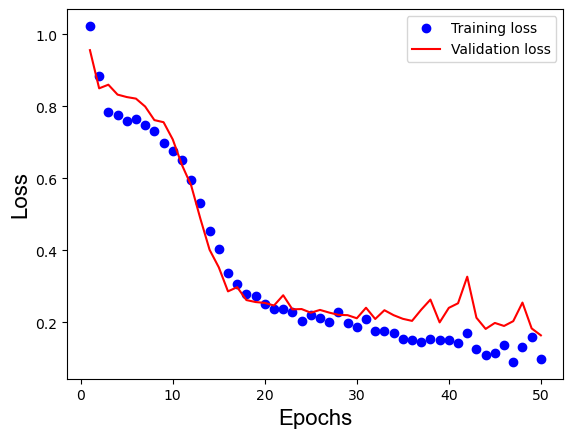

In [8]:
path_loss = pathL+'Train_vali_loss_lnn.jpg'
plot_train_val_loss(train_loss_history,val_loss_history,path_loss)

# Plotting the training and validation accuracy

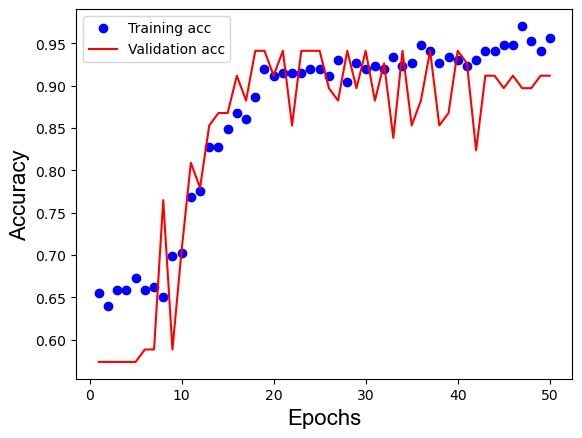

In [9]:
path_acc = pathL+'Train_vali_accuracy_lnn.jpg'
plot_train_val_accuracy(train_accuracy_history,val_accuracy_history,path_acc)

#  Model evaluation, saving, and prediction on the validation set

The model has 26537 trainable parameters
测试集准确率: 0.942


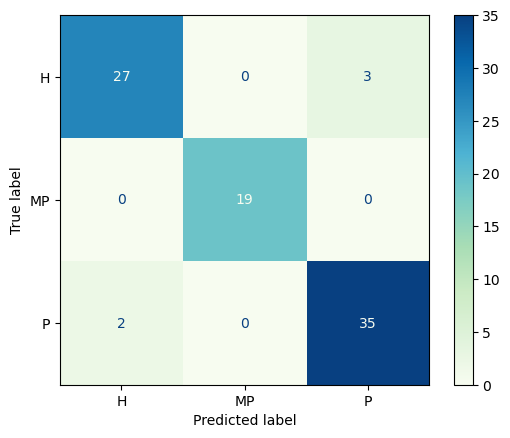

In [10]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

# Model parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Save the entire model
torch.save(model, pathS+'PDD_LNN_'+rdms+'_model.pth')
trained_model = torch.load(pathS+'PDD_LNN_'+rdms+'_model.pth')

# Print model parameter count
print(f"The model has {count_parameters(trained_model)} trainable parameters")
with open(pathS+'LNN_paranums'+rdms+'.txt', 'w') as file:
    # Use print function, automatically handles newlines and string conversion
    file.write(str(count_parameters(trained_model)))

# Test set prediction
test_seq = test_set[0].to(DEVICE)
test_output = evaluate_model(trained_model, test_seq)
_, test_pred = torch.max(test_output, 1)

# Prediction results
test_pred = test_pred.cpu()
test_probs = torch.softmax(test_output, 1).cpu()
test_target = test_set[1].numpy()
test_accuracy = (test_pred == test_target).sum().item() / len(test_target)

# Confusion matrix
target_names = group_name
conf_mat = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=target_names)
disp.plot(cmap="GnBu")  # coolwarm_r, GnBu
# plt.title('Confusion matrix')
plt.savefig(pathS+'_confusion matrix_lnn.jpg', dpi=300, bbox_inches='tight')

# Report analysis accuracy
print(f"Test set accuracy: {round(test_accuracy, 3)}")

# Create a mapping from indices to class labels
label_map = {index: value for index, value in enumerate(group_name)}

# Map indices to class labels
pred_labels = [label_map[idx] for idx in test_pred.tolist()]
pre_data_name = thyroid_blind.mass
Data_store = pd.DataFrame(np.c_[pre_data_name, pred_labels], columns=['SAMPLE', 'PREDICTION'])
Data_store.to_csv(pathS+'Pytorch_LNN_PDD_'+rdms+'_test_result.csv', sep=',', index=False)